# User Steps for Statistics and Benchmarks

This is a user guide for how to load real world data, run data statistics, and perform benchmarks. Alongside performing benchmarks, we will show an example on how to load backtests and compare backtests and benchmarks.

In [1]:
import datetime
from functools import reduce
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import talib
from tqdm import tqdm
import quantstats as qs
from PIL import Image  
qs.extend_pandas()
%matplotlib inline

### Load Portfolio - Real Data

In [2]:
def _retrieve_asset_dict():
    root = os.getcwd()
    data_env = root+"/data_env/"

    files = [_ for _ in os.listdir(data_env) if "parquet" in _]    
    assets_dict = {file: pd.read_parquet(data_env + "/" + file) for file in files}
    counter=0
    for key, value in assets_dict.items():
        if counter==0:
            main_index=value.index
        else:
            main_index=main_index.join(value.index,how="inner")

    for key, value in assets_dict.items():
        tmp_df=value.reindex(main_index)
        tmp_df=tmp_df.fillna(method='ffill')
        assets_dict[key]=tmp_df['close']  
    return assets_dict

def build_portfolio_df(asset_dict):
    portfolio_df = pd.DataFrame()

    for key, value in assets_dict.items():
        key = key.split(".")[0]
        tmp_df = pd.DataFrame(data=value)
        tmp_df.columns=[key]
        portfolio_df = pd.concat([portfolio_df, tmp_df], axis=1)

    portfolio_df.index = pd.to_datetime(portfolio_df.index, errors='coerce').tz_localize(None)
    return portfolio_df

assets_dict = _retrieve_asset_dict()
portfolio_df = build_portfolio_df(assets_dict)
portfolio_df.index.name = 'Date'

In [3]:
portfolio_df.tail(5)

,USMV,EEMV,QUAL,SIZE,MTUM,VLUE,EFAV
Date,,,,,,,
2020-11-17 05:00:00,67.20,59.46,112.47,105.7100,151.45,83.14,71.56
2020-11-18 05:00:00,66.35,59.36,111.14,104.5700,150.73,82.63,71.30
2020-11-19 05:00:00,66.47,59.41,111.29,105.2600,151.95,82.89,71.95
2020-11-20 05:00:00,66.15,59.62,110.46,104.8600,151.22,82.49,72.03
2020-11-23 05:00:00,66.24,59.73,111.23,106.1831,151.31,84.47,71.58


### Real Data Statistics

In [4]:
def retrieve_statistics(portfolio_df):
    sharpe = qs.stats.sharpe(portfolio_df)
    sortino = qs.stats.sortino(portfolio_df) 
    volatility = qs.stats.volatility(portfolio_df) 
    max_drawdown = qs.stats.max_drawdown(portfolio_df) 
    calmar = qs.stats.calmar(portfolio_df)
    df = pd.DataFrame({
        'Sharpe Ratio': round(sharpe, 2), 
        'Sortino Ratio': round(sortino, 2), 
        'Calmar Ratio': round(calmar, 2),
        'Max DrawDown': round(max_drawdown, 2), 
        'Volatility': round(volatility, 2)
    })
    return df


stats_df = retrieve_statistics(portfolio_df)
stats_df

,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max DrawDown,Volatility
USMV,0.75,1.03,0.37,-0.33,0.18
EEMV,0.53,0.70,0.24,-0.32,0.16
QUAL,0.78,1.08,0.43,-0.34,0.20
SIZE,0.66,0.88,0.32,-0.39,0.22
MTUM,0.96,1.33,0.61,-0.34,0.22
VLUE,0.42,0.57,0.18,-0.39,0.23
EFAV,0.53,0.71,0.26,-0.28,0.15


### Real Data Benchmarks

In [11]:
from lib.Benchmarks import RollingPortfolios
portfolio_returns_df = portfolio_df.to_returns().dropna()
in_window = 14
prediction_window = 7

rp_max_return = RollingPortfolios(
    prices=portfolio_returns_df, 
    in_window=in_window, 
    prediction_window=prediction_window, 
    portfolio_type='max_return'
)

rp_max_sharpe = RollingPortfolios(
    prices=portfolio_returns_df, 
    in_window=in_window, 
    prediction_window=prediction_window, 
    portfolio_type='max_sharpe'
)

rp_min_volatility = RollingPortfolios(
    prices=portfolio_returns_df, 
    in_window=in_window, 
    prediction_window=prediction_window, 
    portfolio_type='min_volatility'
)

100%|██████████| 138/138 [00:06<00:00, 21.04it/s]


### Load Backtest

<Figure size 432x288 with 0 Axes>

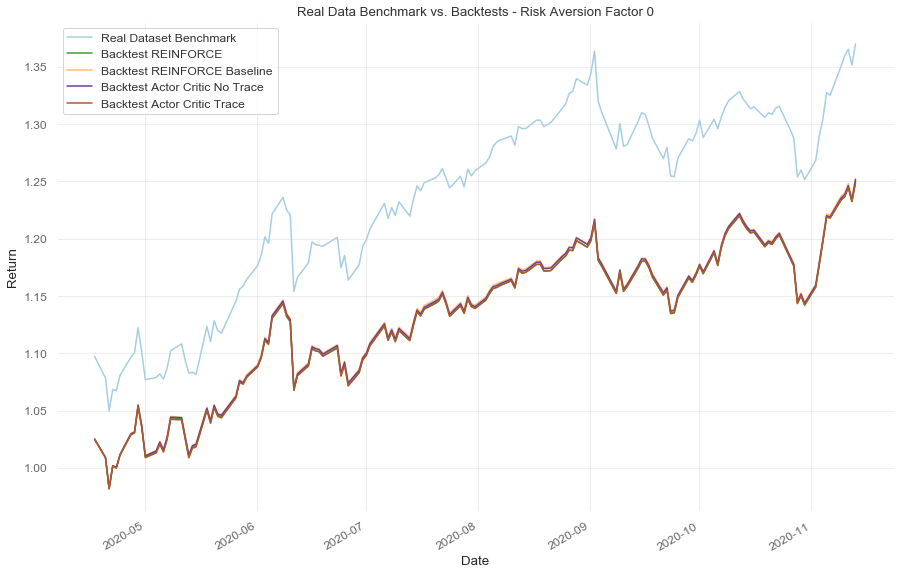

<Figure size 432x288 with 0 Axes>

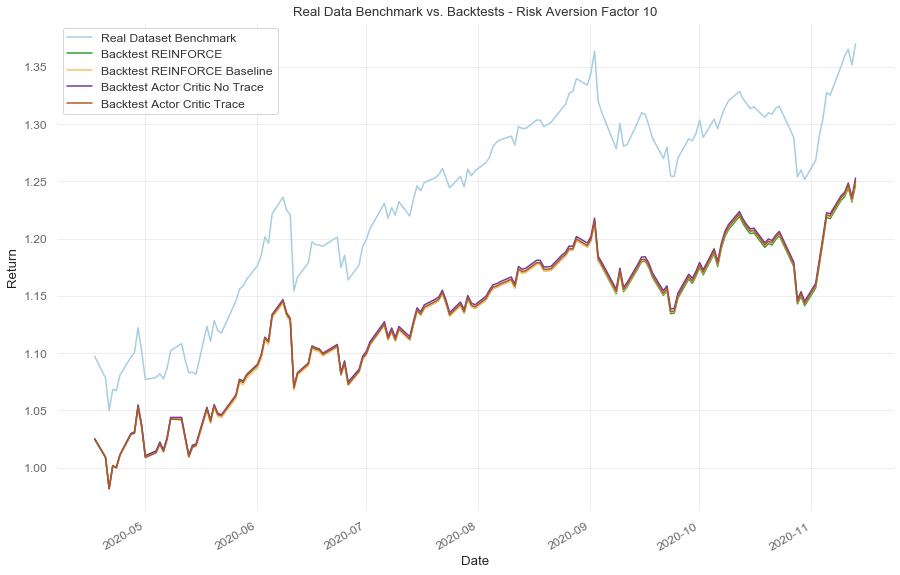

In [12]:
def load_backtest(path, file_name, model_name):
    backtest=pd.read_csv("./{}/{}.csv".format(path, file_name))
    backtest['index']=backtest['index'].astype('datetime64[ns]')
    backtest.rename(columns={'index':'Date','1': model_name}, inplace=True)
    backtest.set_index('Date', inplace=True)
    backtest_stats = retrieve_statistics(backtest)
    return backtest, backtest_stats

def display_graph(backtest, rp_df, factor):
    df = pd.DataFrame({
        'Real Dataset Benchmark': rp_df, 
        'Backtest REINFORCE': backtest['REINFORCE'],
        'Backtest REINFORCE Baseline': backtest['REINFORCE with Baseline'],
        'Backtest Actor Critic No Trace': backtest['Actor Critic No Trace'],
        'Backtest Actor Critic Trace': backtest['Actor Critic Trace']
    })
    df = df.dropna()
    plt.figure()
    df.plot(figsize=(15,10),colormap='Paired', title='Real Data Benchmark vs. Backtests - Risk Aversion Factor {}'.format(factor))
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.show()


def load_backtest_risk_0():
    path = 'backtest_demeaned_risk_aversion'
    backtest_actor_critic_no_trace, backtest_actor_critic_no_trace_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_0_backtest_actor_critic_no_trace', 'Actor Critic No Trace') 
    backtest_actor_critic_trace, backtest_actor_critic_trace_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_0_backtest_actor_critic_trace', 'Actor Critic Trace') 
    backtest_reinforce, backtest_reinforce_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_0_backtest_reinforce', 'REINFORCE') 
    backtest_reinforce_baseline, backtest_reinforce_baseline_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_0_backtest_reinforce_baseline', 'REINFORCE with Baseline')
    
    lst = [backtest_reinforce, backtest_reinforce_baseline, backtest_actor_critic_no_trace, backtest_actor_critic_trace]
    backtest_risk_0 = reduce(lambda left,right: pd.merge(left,right,on='Date'), lst)

    backtest_risk_0_stats = pd.concat([backtest_reinforce_stats, backtest_reinforce_baseline_stats,
                                       backtest_actor_critic_no_trace_stats,backtest_actor_critic_trace_stats])
    return backtest_risk_0, backtest_risk_0_stats

def load_backtest_risk_10():
    path = 'backtest_demeaned_risk_aversion_10'
    backtest_actor_critic_no_trace, backtest_actor_critic_no_trace_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_10_backtest_actor_critic_no_trace', 'Actor Critic No Trace') 
    backtest_actor_critic_trace, backtest_actor_critic_trace_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_10_backtest_actor_critic_trace', 'Actor Critic Trace') 
    backtest_reinforce, backtest_reinforce_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_10_backtest_reinforce', 'REINFORCE') 
    backtest_reinforce_baseline, backtest_reinforce_baseline_stats = load_backtest(path, 'demeaned_return_reward_variance_risk_10_backtest_reinforce_baseline', 'REINFORCE with Baseline')
    
    lst = [backtest_reinforce, backtest_reinforce_baseline, backtest_actor_critic_no_trace, backtest_actor_critic_trace]
    backtest_risk_0 = reduce(lambda left,right: pd.merge(left,right,on='Date'), lst)

    backtest_risk_0_stats = pd.concat([backtest_reinforce_stats, backtest_reinforce_baseline_stats,
                                       backtest_actor_critic_no_trace_stats,backtest_actor_critic_trace_stats])
    return backtest_risk_0, backtest_risk_0_stats


rp_max_return_benchmark = ((rp_max_return.hrp_weights * portfolio_returns_df).sum(axis=1) + 1).cumprod()
rp_max_sharpe_benchmark = ((rp_max_sharpe.hrp_weights * portfolio_returns_df).sum(axis=1) + 1).cumprod()
rp_min_volatility_benchmark = ((rp_min_volatility.hrp_weights * portfolio_returns_df).sum(axis=1) + 1).cumprod()

benchmarks = pd.DataFrame({
    'Benchmark - Max Return': rp_max_return_benchmark, 
    'Benchmark - Max Sharpe': rp_max_sharpe_benchmark,
    'Benchmark - Min Volatility': rp_min_volatility_benchmark
})

backtest_risk_0, backtest_risk_0_stats = load_backtest_risk_0()
display_graph(backtest_risk_0, rp_max_return_benchmark, factor='0')

backtest_risk_10, backtest_risk_10_stats = load_backtest_risk_10()
display_graph(backtest_risk_10, rp_max_return_benchmark, factor='10')


In [13]:
backtest_risk_0_stats

,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max DrawDown,Volatility
REINFORCE,1.92,2.66,6.13,-0.07,0.19
REINFORCE with Baseline,1.93,2.69,6.26,-0.07,0.19
Actor Critic No Trace,1.94,2.69,6.24,-0.07,0.18
Actor Critic Trace,1.91,2.66,6.20,-0.07,0.18


In [14]:
backtest_risk_10_stats

,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max DrawDown,Volatility
REINFORCE,1.90,2.63,6.10,-0.07,0.18
REINFORCE with Baseline,1.92,2.67,6.21,-0.07,0.18
Actor Critic No Trace,1.94,2.70,6.23,-0.07,0.18
Actor Critic Trace,1.93,2.68,6.24,-0.07,0.18
